In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import datasets, transforms
import numpy as np
from torchsummary import summary
from tqdm import tqdm
import time


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:

transform = transforms.Compose([transforms.ToTensor()])



In [ ]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# classes 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = "cuda" if cuda else "cpu"
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=4, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=4)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

CUDA Available? True


plane   dog  deer  deer


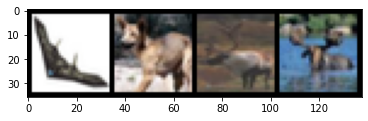

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    # img = img * std + mean     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
print(train.data.shape)

(50000, 32, 32, 3)


In [ ]:
data = iter(train_loader)

In [ ]:
data, target = next(data)

In [ ]:
type(data)
# data

torch.Tensor

In [ ]:
data.shape

torch.Size([4, 3, 32, 32])

In [ ]:
m =  np.mean(train.data, axis=(0,1,2))
print("mean:",m)
s = np.std(train.data, axis=(0,1,2))
print("std:", s)

mean: [125.30691805 122.95039414 113.86538318]
std: [62.99321928 62.08870764 66.70489964]


In [ ]:
# mean = (125.306/255, 122.950/255, 113.865/255,)
# std = (62.993/255, 62.088/255, 66.704/255, )

In [ ]:
m = tuple(m/255)
m

(0.49139967861519607, 0.48215840839460783, 0.44653091444546567)

In [ ]:
s = tuple(s/255)
s

(0.24703223246328176, 0.24348512800005648, 0.26158784172796473)

In [ ]:
!pip install torchtoolbox
from torchtoolbox.transform import Cutout

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomCrop(size=32,padding=1),
                                       Cutout(p=0.25,scale=(0.02, 0.10)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=m, std=s)
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=m, std=s)
                                       ])


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='../cifar10_data', train=True,
                                        download=True, transform=train_transforms)


testset = torchvision.datasets.CIFAR10(root='../cifar10_data', train=False,
                                       download=True, transform=test_transforms)



Extracting ../cifar10_data/cifar-10-python.tar.gz to ../cifar10_data
Files already downloaded and verified


In [ ]:
SEED = 101

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=4)


CUDA Available? True


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()

#         self.conv_block_1 = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(32))
        
#         self.conv_block_2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(128))
        
#         self.pool = nn.MaxPool2d(2, 2)

#         self.conv_block_3 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False, dilation=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, groups=256, padding=0, bias=False),
#             nn.Conv2d(256, 512, kernel_size=1, padding=0, bias=False),
#             nn.BatchNorm2d(512))
        
#         self.conv_block_4 = nn.Sequential(
#             nn.Conv2d(512, 256, kernel_size=1, padding=0, bias=False,),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, groups=256, padding=0, bias=False),
#             nn.Conv2d(256, 256, 1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(256),
#             nn.Conv2d(256, 64, 1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(64, 64, kernel_size=3, groups=64, padding=0, bias=False),
#             nn.Conv2d(64, 10, 1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(10)
#             )
        
#         self.gap = nn.AdaptiveAvgPool2d(1)
        
        

#     def forward(self, x):
#         x = self.conv_block_1(x)
#         x = self.conv_block_2(x) 
#         x = self.pool(x) 
#         x = self.conv_block_3(x) 
#         # x = self.pool(x) 
#         x = self.conv_block_4(x)  

#         x = self.gap(x)

#         x = x.view(-1, 10)
      
#         return x



In [ ]:
# model = Net().to(device)

In [ ]:
# summary(model, input_size=(3, 32, 32))

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False, groups=4),
            nn.BatchNorm2d(32))
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False, groups=8),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False, groups=16),
            nn.BatchNorm2d(128))
        
        self.pool = nn.MaxPool2d(2, 2)

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False, dilation=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False, groups=32),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, groups=256, padding=1, bias=False),
            nn.Conv2d(256, 512, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(512))
        
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, padding=0, bias=False, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, groups=256, padding=1, bias=False),
            nn.Conv2d(256, 256, kernel_size=1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 64, 1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Conv2d(64, 64, kernel_size=3, groups=64, padding=0, bias=False),
            nn.Conv2d(64, 10, 1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
            )
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        

    def forward(self, x):
        
        x = self.conv_block_1(x)
        x = self.conv_block_2(x) 
        x = self.pool(x) 
        x = self.conv_block_3(x) 
        # x = self.pool(x) 
        x = self.conv_block_4(x)  

        x = self.gap(x)

        x = x.view(-1, 10)
      
        return x



In [ ]:
from copy import deepcopy

d = {
        'misclassified': [],
        'train_losses': [],
        'test_losses': [],
        'train_accuracy': [],
        'test_accuracy': []
    }

total = ['L2+BN'] # , 'GBN', 'L2+GBN'
tracker = {}
for item in total:
    tracker[item] = deepcopy(d)

# tracker['L1+BN']['test_accuracy'].append(100)
for k, v in tracker.items():
    print(k, ">>>>", v)

L2+BN >>>> {'misclassified': [], 'train_losses': [], 'test_losses': [], 'train_accuracy': [], 'test_accuracy': []}


In [ ]:
model2 = Net2().to(device)

In [ ]:
summary(model2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           1,152
       BatchNorm2d-5           [-1, 32, 32, 32]              64
            Conv2d-6           [-1, 64, 32, 32]           2,304
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]           4,608
      BatchNorm2d-10          [-1, 128, 32, 32]             256
        MaxPool2d-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 256, 14, 14]         294,912
           Conv2d-13          [-1, 256, 14, 14]          18,432
      BatchNorm2d-14          [-1, 256,

In [ ]:
# for epoch in range(20):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model2(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 500 == 0:    # print every 500 mini-batches and at 0th batch as well
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 500))
#             running_loss = 0.0

# print('Finished Training')

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_test(model, device, train_loader, optimizer, epochs, scheduler, test, test_loader, type_, tracker, l1_lambda=None, l2_lambda=None):
    if test and not test_loader:
        raise ValueError("`test`= True but `test_loader` not provided")

    
    model.train()

    for epoch in range(epochs):
        l1 = torch.tensor(0, requires_grad=False)
        correct = 0
        processed = 0
        train_loss = 0

        print(f"\n\nepoch: {epoch + 1}")
        # pbar = tqdm(train_loader)

        if "l2" in type_.lower():
            optimizer.param_groups[0]['weight_decay'] = l2_lambda
            
        for i, data in enumerate(train_loader, 0):
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)

            optimizer.zero_grad()  # set the gradients top zero to avoid accumulatin them over the epochs

            output = model(inputs)  # model's output

            loss = criterion(output, target)

            # if "l1" in type_.lower():
            #     for param in model.parameters():
            #         l1 = l1 + param.abs().sum()
            #     loss = loss + l1_lambda * l1.item()

            loss.backward()
            optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

            train_loss += loss.item()
            if i%500 == 0:
              print(f'epoch:{epoch+1}.... batch:{i+1}...loss:{train_loss:.4f}')

        train_loss /= len(train_loader.dataset)
        acc = 100 * correct / processed
        tracker[type_]['train_losses'].append(train_loss)
        tracker[type_]['train_accuracy'].append(acc)

        # pbar.set_description(desc=f'loss={loss.item()} batch_id={batch_idx}')
        if scheduler:
            print(f'\n>>>lr: {scheduler.get_last_lr()[0]}')
            scheduler.step()
        print('\nTrain set: \t\t Accuracy: {}/{} ({:.6f}%)'.format(correct, len(train_loader.dataset),
                                                                   100.0 * correct / len(train_loader.dataset)))

        if test:
            model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    test_loss +=criterion(output, target).sum().item()  # sum up batch loss
                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()
                    for i in range(len(pred)):
                        if pred[i] != target[i]:
                            tracker[type_]['misclassified'].append((data[i], pred[i], target[i]))

            test_loss /= len(test_loader.dataset)
            t_acc = 100.0 * correct / len(test_loader.dataset)
            tracker[type_]['test_losses'].append(test_loss)
            tracker[type_]['test_accuracy'].append(t_acc)

            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset), t_acc))

## >step changed to 4 for scheduler, l2 seems pretty high in comparison to the code reaching 80% in 6th epoch(l2=2e-3) -> to reduce l2 in next run to 3e-3 from 5e-3

## >step changed to 3, gamma=0.579, l2=2.5e-3 from step=4, gamma=0.379, l2=3e-3

## >include image augmentation next: weight decay decreased:l2=8e-4 and step=3, gamma=0.379
                                      
      >transforms.RandomHorizontalFlip()
      >transforms.RandomCrop(size=32,padding=1)
                                     
## >add cutout next, using torchtoolbox --> Regularization effect increased as the difference between the accuracies decreased and train acc. reaches 80% in more epochs

## >next try to increase lr or change the way it decreases --> best result so far with lr=0.007

## > lr=0.009 gave tr=90.11 %, te= 86.83%, diff of 3.28%

In [ ]:
l1 = None
l2 = 8e-4
for combo in total:
  start = time.perf_counter()
  model2 = Net2().to(device)

  optimizer = optim.SGD(model2.parameters(), lr=0.007, momentum=0.9, nesterov=True)
  scheduler = StepLR(optimizer=optimizer, step_size=2, gamma=0.579)

  train_test(model2, device, trainloader, optimizer, epochs=15, scheduler=scheduler, test=True, test_loader=testloader,
            type_=combo, tracker=tracker, l1_lambda=l1, l2_lambda=l2)
  end = time.perf_counter()
  print(f"\n\nTime taken for:{combo} = {end-start:.3f}")



epoch: 1
epoch:1.... batch:1...loss:2.2917
epoch:1.... batch:501...loss:789.5587
epoch:1.... batch:1001...loss:1405.4569
epoch:1.... batch:1501...loss:1940.3502

>>>lr: 0.007

Train set: 		 Accuracy: 27852/50000 (55.704000%)

Test set: Average loss: 0.0306, Accuracy: 6628/10000 (66.280000%)



epoch: 2
epoch:2.... batch:1...loss:0.5845
epoch:2.... batch:501...loss:514.4419
epoch:2.... batch:1001...loss:965.4503
epoch:2.... batch:1501...loss:1380.2340

>>>lr: 0.007

Train set: 		 Accuracy: 34036/50000 (68.072000%)

Test set: Average loss: 0.0233, Accuracy: 7412/10000 (74.120000%)



epoch: 3
epoch:3.... batch:1...loss:0.6107
epoch:3.... batch:501...loss:340.7302
epoch:3.... batch:1001...loss:673.3126
epoch:3.... batch:1501...loss:1002.6483

>>>lr: 0.004053

Train set: 		 Accuracy: 38338/50000 (76.676000%)

Test set: Average loss: 0.0215, Accuracy: 7606/10000 (76.060000%)



epoch: 4
epoch:4.... batch:1...loss:0.2981
epoch:4.... batch:501...loss:300.5056
epoch:4.... batch:1001...loss:6